# Description

It summarizes the GLS (Generalized Least Squares) results, adjusting pvalues using FDR, and saving the final results to a pickle file for later use.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from phenoplier_plots import qqplot

# Settings

In [2]:
N_LVS = 987
PROJECTS_TRAIT_KEY = "CHRONOTYPE"

In [3]:
# Parameters
PHENOPLIER_NOTEBOOK_FILEPATH = (
    "projects/chronotype/nbs/30_gls_phenoplier/05-summarize.ipynb"
)

In [4]:
INPUT_DIR = conf.PROJECTS[PROJECTS_TRAIT_KEY]["RESULTS_DIR"] / "gls_phenoplier" / "gls"
display(INPUT_DIR)
assert INPUT_DIR.exists()

INPUT_PATTERN = "*.tsv.gz"
display(INPUT_PATTERN)

PosixPath('/opt/data/projects/chronotype/results/gls_phenoplier/gls')

'*.tsv.gz'

In [5]:
PVALUE_COLUMN = "pvalue"

In [6]:
OUTPUT_DIR = conf.PROJECTS[PROJECTS_TRAIT_KEY]["RESULTS_DIR"] / "gls_phenoplier"
display(OUTPUT_DIR)
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

PosixPath('/opt/data/projects/chronotype/results/gls_phenoplier')

# Load data

## Phenotype info

In [7]:
pheno_info = pd.read_csv(conf.PROJECTS[PROJECTS_TRAIT_KEY]["TRAITS_INFO_FILE"])

In [8]:
pheno_info.shape

(1, 4)

In [9]:
pheno_info.head()

,id,gwas_file,sample_size,n_cases
0,chronotype,chronotype_raw_BOLT.output_HRC.only_plus.metri...,449734,NaN


In [10]:
assert pheno_info["id"].is_unique

In [11]:
N_PHENOTYPES = pheno_info.shape[0]

In [12]:
# pheno_code_to_desc_map = pheno_info.set_index("short_code")[
#     "unique_description"
# ].to_dict()

## GLS results

### Get files list

In [13]:
INPUT_FILES = list(INPUT_DIR.glob(INPUT_PATTERN))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/projects/chronotype/results/gls_phenoplier/gls/chronotype_raw_BOLT.output_HRC.only_plus.metrics_maf0.001_hwep1em12_info0.3.txt-gls_phenoplier.tsv.gz')]

In [14]:
_tmp = len(INPUT_FILES)
display(_tmp)
assert _tmp == N_PHENOTYPES

1

### Read results

In [15]:
INPUT_FILES[0].name.split("gls_phenoplier.")[0]

'chronotype_raw_BOLT.output_HRC.only_plus.metrics_maf0.001_hwep1em12_info0.3.txt-'

In [16]:
dfs = [
    pd.read_csv(
        f, sep="\t", usecols=["lv", "beta", "beta_se", "pvalue_onesided"]
    ).assign(phenotype=f.name.split("gls_phenoplier.")[0])
    for f in INPUT_FILES
]

In [17]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1

In [18]:
dfs = pd.concat(dfs, axis=0, ignore_index=True).rename(
    columns={"pvalue_onesided": PVALUE_COLUMN}
)

In [19]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987, 5)

In [20]:
# # add phenotype description
# dfs = dfs.assign(
#     phenotype_desc=dfs["phenotype"].apply(lambda x: pheno_code_to_desc_map[x])
# )
# dfs = dfs[["phenotype", "phenotype_desc", "lv", "pvalue"]]

In [21]:
dfs.head()

,lv,beta,beta_se,pvalue,phenotype
0,LV402,0.854006,0.125185,4.900525e-12,chronotype_raw_BOLT.output_HRC.only_plus.metri...
1,LV367,0.565019,0.124547,2.910352e-06,chronotype_raw_BOLT.output_HRC.only_plus.metri...
2,LV156,0.547662,0.125244,6.230358e-06,chronotype_raw_BOLT.output_HRC.only_plus.metri...
3,LV215,0.431578,0.125153,2.837635e-04,chronotype_raw_BOLT.output_HRC.only_plus.metri...
4,LV727,0.438011,0.127459,2.965273e-04,chronotype_raw_BOLT.output_HRC.only_plus.metri...


In [22]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

### FDR adjust

In [23]:
adj_pval = multipletests(dfs[PVALUE_COLUMN], alpha=0.05, method="fdr_bh")
dfs = dfs.assign(fdr=adj_pval[1])

In [24]:
dfs.shape

(987, 6)

In [25]:
dfs.head()

,lv,beta,beta_se,pvalue,phenotype,fdr
0,LV402,0.854006,0.125185,4.900525e-12,chronotype_raw_BOLT.output_HRC.only_plus.metri...,4.836818e-09
1,LV367,0.565019,0.124547,2.910352e-06,chronotype_raw_BOLT.output_HRC.only_plus.metri...,1.436259e-03
2,LV156,0.547662,0.125244,6.230358e-06,chronotype_raw_BOLT.output_HRC.only_plus.metri...,2.049788e-03
3,LV215,0.431578,0.125153,2.837635e-04,chronotype_raw_BOLT.output_HRC.only_plus.metri...,4.460674e-02
4,LV727,0.438011,0.127459,2.965273e-04,chronotype_raw_BOLT.output_HRC.only_plus.metri...,4.460674e-02


# QQ-plot

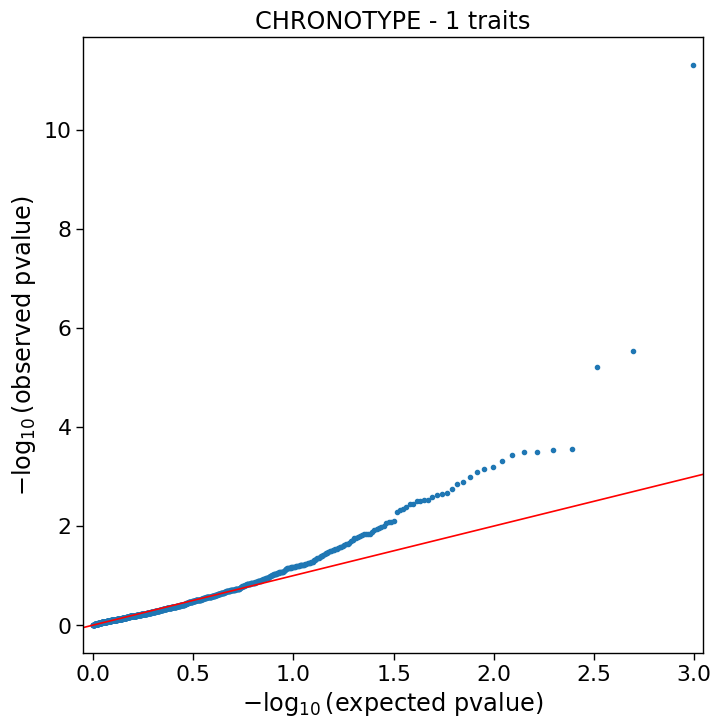

In [26]:
with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = qqplot(dfs["pvalue"])
    ax.set_title(f"{PROJECTS_TRAIT_KEY} - {N_PHENOTYPES} traits")

# Top hits

In [27]:
with pd.option_context("display.max_columns", None, "display.max_colwidth", None):
    _tmp = dfs.sort_values("fdr")  # .drop(columns="phenotype")
    _tmp = _tmp[_tmp["fdr"] < 0.05]
    display(_tmp.head(50))

,lv,beta,beta_se,pvalue,phenotype,fdr
0,LV402,0.854006,0.125185,4.900525e-12,chronotype_raw_BOLT.output_HRC.only_plus.metrics_maf0.001_hwep1em12_info0.3.txt-,4.836818e-09
1,LV367,0.565019,0.124547,2.910352e-06,chronotype_raw_BOLT.output_HRC.only_plus.metrics_maf0.001_hwep1em12_info0.3.txt-,1.436259e-03
2,LV156,0.547662,0.125244,6.230358e-06,chronotype_raw_BOLT.output_HRC.only_plus.metrics_maf0.001_hwep1em12_info0.3.txt-,2.049788e-03
3,LV215,0.431578,0.125153,2.837635e-04,chronotype_raw_BOLT.output_HRC.only_plus.metrics_maf0.001_hwep1em12_info0.3.txt-,4.460674e-02
4,LV727,0.438011,0.127459,2.965273e-04,chronotype_raw_BOLT.output_HRC.only_plus.metrics_maf0.001_hwep1em12_info0.3.txt-,4.460674e-02
5,LV616,0.427082,0.125028,3.198417e-04,chronotype_raw_BOLT.output_HRC.only_plus.metrics_maf0.001_hwep1em12_info0.3.txt-,4.460674e-02
6,LV797,0.429151,0.125676,3.211664e-04,chronotype_raw_BOLT.output_HRC.only_plus.metrics_maf0.001_hwep1em12_info0.3.txt-,4.460674e-02
7,LV228,0.422892,0.125031,3.615541e-04,chronotype_raw_BOLT.output_HRC.only_plus.metrics_maf0.001_hwep1em12_info0.3.txt-,4.460674e-02


# Optimize data types

In [28]:
dfs.dtypes

lv            object
beta         float64
beta_se      float64
pvalue       float64
phenotype     object
fdr          float64
dtype: object

In [29]:
dfs.memory_usage()

Index         128
lv           7896
beta         7896
beta_se      7896
pvalue       7896
phenotype    7896
fdr          7896
dtype: int64

In [30]:
dfs["phenotype"] = dfs["phenotype"].astype("category")
dfs["lv"] = dfs["lv"].astype("category")

In [31]:
dfs.dtypes

lv           category
beta          float64
beta_se       float64
pvalue        float64
phenotype    category
fdr           float64
dtype: object

In [32]:
dfs.head()

,lv,beta,beta_se,pvalue,phenotype,fdr
0,LV402,0.854006,0.125185,4.900525e-12,chronotype_raw_BOLT.output_HRC.only_plus.metri...,4.836818e-09
1,LV367,0.565019,0.124547,2.910352e-06,chronotype_raw_BOLT.output_HRC.only_plus.metri...,1.436259e-03
2,LV156,0.547662,0.125244,6.230358e-06,chronotype_raw_BOLT.output_HRC.only_plus.metri...,2.049788e-03
3,LV215,0.431578,0.125153,2.837635e-04,chronotype_raw_BOLT.output_HRC.only_plus.metri...,4.460674e-02
4,LV727,0.438011,0.127459,2.965273e-04,chronotype_raw_BOLT.output_HRC.only_plus.metri...,4.460674e-02


In [33]:
dfs.memory_usage()

Index          128
lv           42934
beta          7896
beta_se       7896
pvalue        7896
phenotype     1103
fdr           7896
dtype: int64

# Save

## Pickle

In [34]:
output_file = OUTPUT_DIR / "gls-summary.pkl.gz"
display(output_file)

PosixPath('/opt/data/projects/chronotype/results/gls_phenoplier/gls-summary.pkl.gz')

In [35]:
dfs.to_pickle(output_file)

## Text

In [36]:
output_file = OUTPUT_DIR / "gls-summary.tsv.gz"
display(output_file)

PosixPath('/opt/data/projects/chronotype/results/gls_phenoplier/gls-summary.tsv.gz')

In [37]:
dfs.to_csv(output_file, sep="\t", index=False)